# 1. Setup

In [ ]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.ndimage import binary_dilation

In [ ]:
import io
import base64
from IPython.display import HTML, display

In [ ]:
sys.path.append(str(Path().resolve().parent))

In [ ]:
pd.set_option(
    "display.float_format",
    lambda x: f"{x:.2e}" if abs(x) < 0.01 and x != 0 else f"{x:.2f}",
)
pd.set_option('display.max_columns', 100)
pd.set_option("display.max_rows", 100)

In [ ]:
SEGMENT_C = ["county", "product_type", "is_business"]
CATEGORICAL_C = ["county", "product_type", "is_business", "is_consumption"]
TARGET_C = [
    "county",
    "product_type",
    "is_business",
    "is_consumption",
    "datetime",
]
RAND = 10

In [ ]:
RAW_DATA_PATH = "../raw_data/"
ADDITIONAL_DATA_PATH = "../additional_data/"

In [ ]:
from utils.loading import load_all_raw_data
from utils.preprocessing import process_all_dfs
from utils.merging import merge_all_dfs

In [ ]:
from utils.feature_engineering import (
    get_lag,
    get_moving_average,
    add_cyclic_datetime_features,
)

# 2. Processing

In [ ]:
processed_dfs = process_all_dfs(
    load_all_raw_data(RAW_DATA_PATH, ADDITIONAL_DATA_PATH)
)

In [ ]:
processed_dfs.keys()

dict_keys(['train', 'gas_prices', 'client', 'electricity_prices', 'forecast_weather', 'historical_weather', 'station_county_mapping', 'county_id_to_name_map', 'holidays'])

In [ ]:
df = merge_all_dfs(processed_dfs)

In [ ]:
for lag in [2, 3, 7]:
    df = df.merge(
        get_lag(processed_dfs["train"][TARGET_C + ["target"]], lag=lag),
        on=TARGET_C,
    )

In [ ]:
df = add_cyclic_datetime_features(df)

In [ ]:
for window in [24, 24 * 3, 24 * 7, 24 * 14]:
    df = df.merge(
        get_moving_average(
            processed_dfs["train"]
            .set_index("datetime")
            .sort_index()
            .groupby(CATEGORICAL_C, observed=True, as_index=False),
            window=window,
        ).dropna(),
        on=TARGET_C,
    )

In [ ]:
df["t_over_cap"] = (df["2d_lag_target"] / df["installed_capacity"]).astype(
    "float32"
)
df["t_over_eic"] = (df["2d_lag_target"] / df["eic_count"]).astype("float32")
df["cap_per_eic"] = (df["installed_capacity"] / df["eic_count"]).astype(
    "float32"
)

In [ ]:
df.head()

,county,product_type,is_business,is_consumption,datetime,target,data_block_id,date,dst,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,f1_temperature,f1_dewpoint,f1_snowfall_mm,f1_total_precipitation_mm,f1_cloudcover_low,f1_cloudcover_mid,f1_cloudcover_high,f1_cloudcover_total,f1_u_component,f1_v_component,f1_windspeed,f1_direct_solar_radiation,f1_surface_solar_radiation_downwards,h2_temperature,h2_dewpoint,h2_snowfall_mm,h2_rain_mm,h2_surface_pressure,h2_cloudcover_low,h2_cloudcover_mid,h2_cloudcover_high,h2_cloudcover_total,h2_windspeed,h2_u_component,h2_v_component,h2_shortwave_radiation,h2_direct_solar_radiation,h2_diffuse_radiation,national_holiday,observance_day,season_event,2d_lag_target,3d_lag_target,7d_lag_target,hour_sin,hour_cos,weekday_sin,weekday_cos,day_of_month_sin,day_of_month_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,quarter_sin,quarter_cos,24h_ma_2d_lag_target,72h_ma_2d_lag_target,168h_ma_2d_lag_target,336h_ma_2d_lag_target,t_over_cap,t_over_eic,cap_per_eic
0,0,1,False,False,2021-09-17,4.00e-03,16,2021-09-17,True,108,952.89,47.90,48.90,91.44,8.47,5.52,0.00,0.00,78,49,62,96,-3.48,0.30,3.50,0.00,0.00,8.20,3.02,0.00,0.00,1011.42,6,0,0,5,4.83,3.31,-3.48,0,0,0,0,0,0,0.66,0.87,0.04,0.00,1.00,-0.43,-0.90,-0.36,-0.93,-1.00,-1.84e-16,-0.97,-0.23,-0.97,-0.24,-1.00,-1.84e-16,94.75,63.75,62.59,79.61,6.96e-04,6.14e-03,8.82
1,0,1,False,True,2021-09-17,134.93,16,2021-09-17,True,108,952.89,47.90,48.90,91.44,8.47,5.52,0.00,0.00,78,49,62,96,-3.48,0.30,3.50,0.00,0.00,8.20,3.02,0.00,0.00,1011.42,6,0,0,5,4.83,3.31,-3.48,0,0,0,0,0,0,128.98,120.78,90.14,0.00,1.00,-0.43,-0.90,-0.36,-0.93,-1.00,-1.84e-16,-0.97,-0.23,-0.97,-0.24,-1.00,-1.84e-16,88.57,92.62,89.35,89.42,0.14,1.19,8.82
2,0,2,False,False,2021-09-17,0.00,16,2021-09-17,True,17,166.40,47.90,48.90,91.44,8.47,5.52,0.00,0.00,78,49,62,96,-3.48,0.30,3.50,0.00,0.00,8.20,3.02,0.00,0.00,1011.42,6,0,0,5,4.83,3.31,-3.48,0,0,0,0,0,0,0.00,0.00,0.00,0.00,1.00,-0.43,-0.90,-0.36,-0.93,-1.00,-1.84e-16,-0.97,-0.23,-0.97,-0.24,-1.00,-1.84e-16,19.75,13.31,12.80,16.47,0.00,0.00,9.79
3,0,2,False,True,2021-09-17,26.78,16,2021-09-17,True,17,166.40,47.90,48.90,91.44,8.47,5.52,0.00,0.00,78,49,62,96,-3.48,0.30,3.50,0.00,0.00,8.20,3.02,0.00,0.00,1011.42,6,0,0,5,4.83,3.31,-3.48,0,0,0,0,0,0,21.43,20.62,17.02,0.00,1.00,-0.43,-0.90,-0.36,-0.93,-1.00,-1.84e-16,-0.97,-0.23,-0.97,-0.24,-1.00,-1.84e-16,17.52,16.83,16.79,16.77,0.13,1.26,9.79
4,0,3,False,False,2021-09-17,0.19,16,2021-09-17,True,687,7199.88,47.90,48.90,91.44,8.47,5.52,0.00,0.00,78,49,62,96,-3.48,0.30,3.50,0.00,0.00,8.20,3.02,0.00,0.00,1011.42,6,0,0,5,4.83,3.31,-3.48,0,0,0,0,0,0,0.72,0.88,0.62,0.00,1.00,-0.43,-0.90,-0.36,-0.93,-1.00,-1.84e-16,-0.97,-0.23,-0.97,-0.24,-1.00,-1.84e-16,751.88,505.17,495.51,632.40,9.99e-05,1.05e-03,10.48



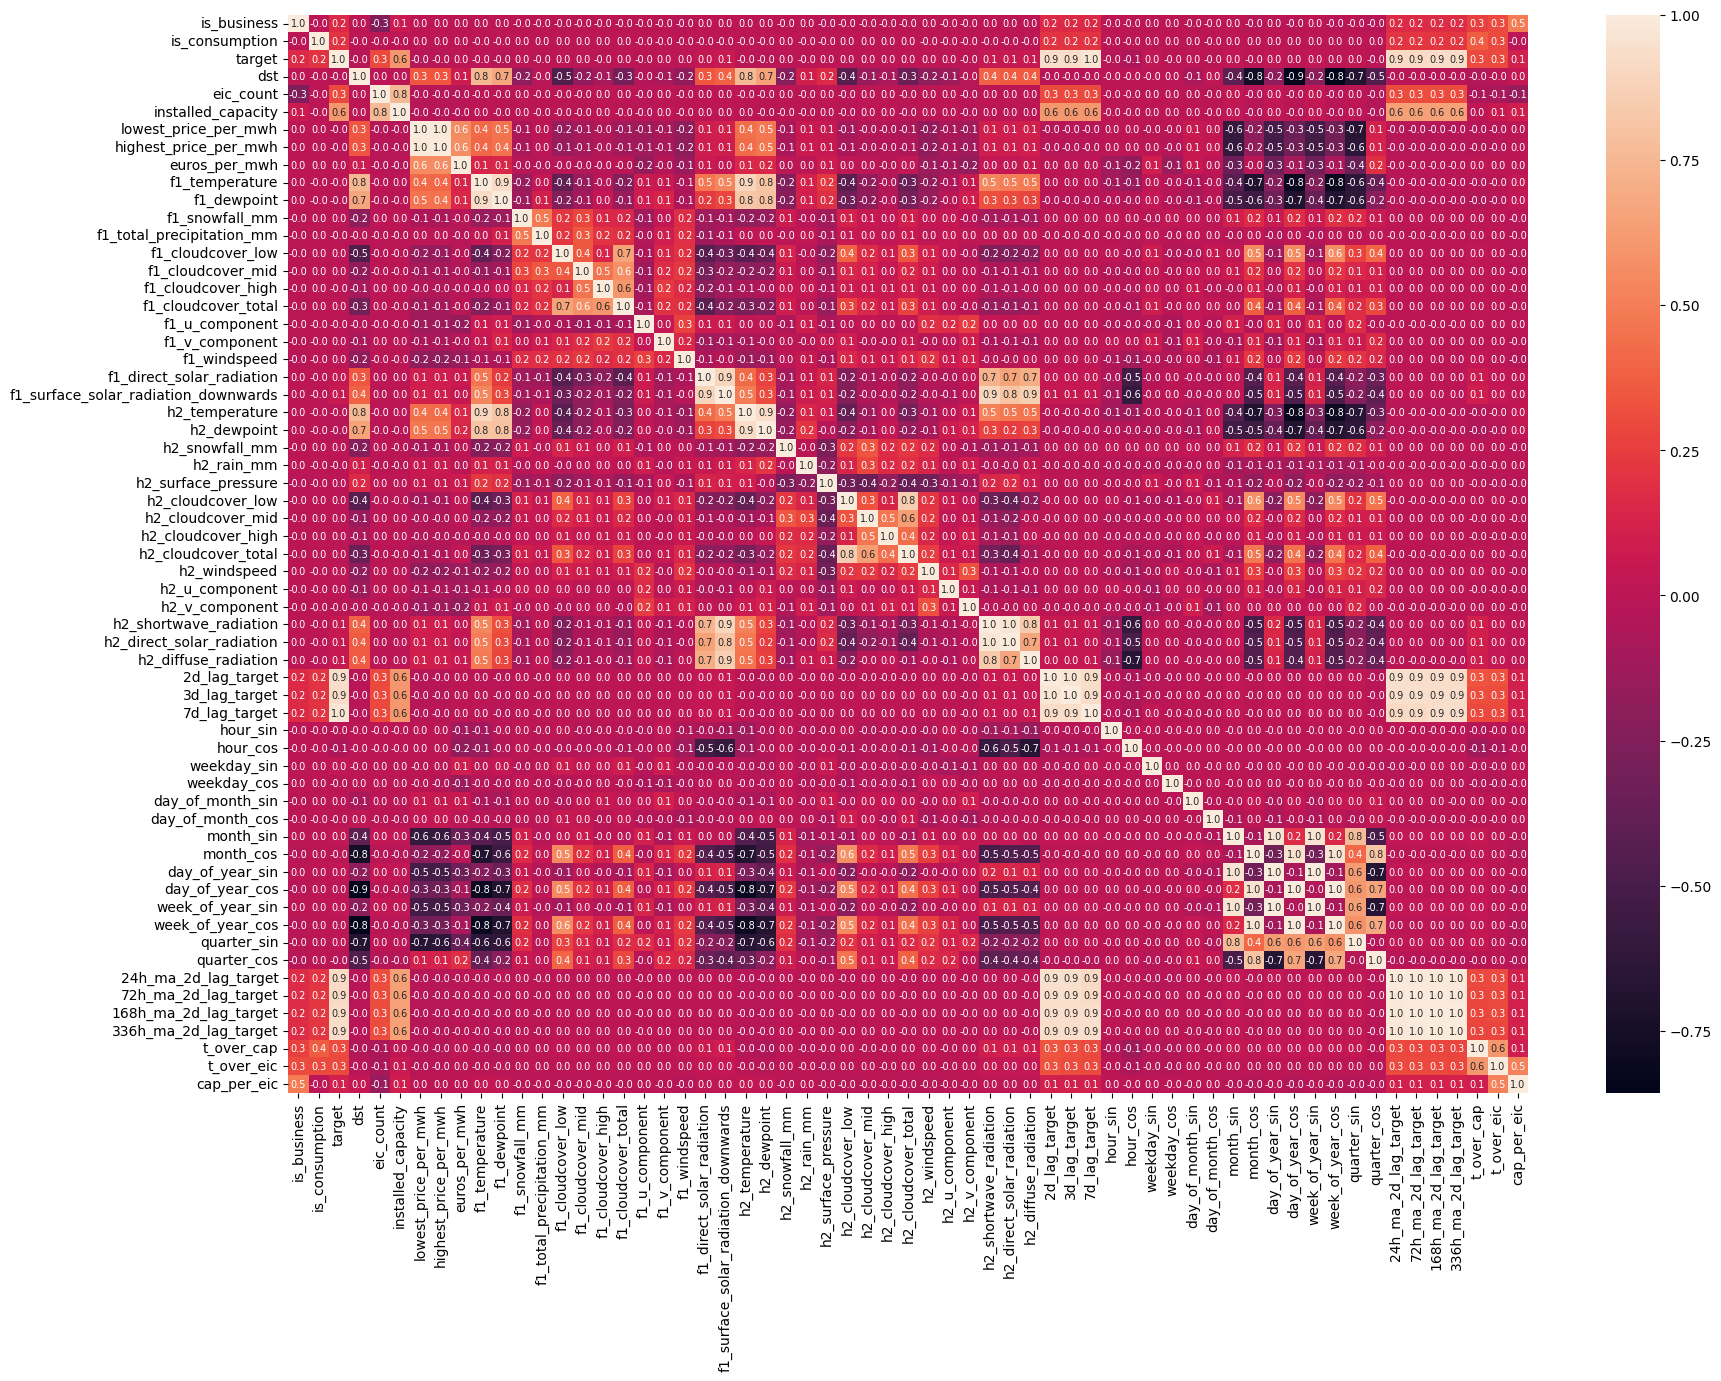

In [ ]:
w, h = 20, 14

fig, ax = plt.subplots(figsize=(w, h))
# plt.figure(figsize=(w, h))

sns.heatmap(
    df.drop(
        columns=df.select_dtypes(["category"]).columns.tolist()
        + [
            "datetime",
            "data_block_id",
            "date",
        ]
    ).corr(),
    annot=True,
    fmt=".1f",
    annot_kws={"size": 7},
)


buf = io.BytesIO()
fig.savefig(buf, format="png", bbox_inches="tight")
buf.seek(0)
img_base64 = base64.b64encode(buf.getvalue()).decode("utf-8")

html_code = (
    '<div style="overflow-x: auto; width: 100%;">'
    '<img src="data:image/png;base64,{}" style="display: block; max-width: none; width: auto;">'
    "</div>"
).format(img_base64)

display(HTML(html_code))
plt.close(fig)
# plt.show()

# 3. Cross Validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit